<a href="https://colab.research.google.com/github/ImSittingOnSalt/Pizza-or-not/blob/main/Nuuro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Создание нейронной сети для распознавания растений на изображениях.**

**Инициализация всех необходимых библиотек**



In [30]:
import random
import numpy as np
from PIL import Image
import os
import pathlib
import matplotlib.pyplot as plt
from os import listdir

import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAvgPool2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
import visualkeras

### **Обработка данных:**


*   Загружает изображения из папок "pizza" и "not_pizza"
*   Разделяет данные на обучающую, валидационную и тестовую выборки с помощью `train_test_split`.

*   Создает датагенератор `ImageDataGenerator` для аугментации данных
*   Подготавливает данные для подачи в модель, включая изменение размера и нормализацию.





In [4]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/pizza_not_pizza/pizza/'

Mounted at /content/drive


In [5]:
# Получаю имена классов
data_dir = pathlib.Path('/content/drive/My Drive/pizza_not_pizza/')
class_names = [item.name for item in data_dir.glob('*')][:2]
print(class_names)

['pizza', 'not_pizza']


In [6]:
pizza_dir = '/content/drive/My Drive/pizza_not_pizza/pizza/'         #дирректории классов
not_pizza_dir = '/content/drive/My Drive/pizza_not_pizza/not_pizza/'

len_pizza_img = len(os.listdir(pizza_dir))          #сколько фотов пицы......
len_not_pizza_img = len(os.listdir(not_pizza_dir))
print(len_pizza_img, len_not_pizza_img)

983 983


In [7]:
# Разделение на тренировочный и валидационный наборы
not_pizza = [(os.path.join(not_pizza_dir, image), 0) for image in os.listdir(os.path.join(not_pizza_dir)) if image.split(".")[1] == "jpg"]
pizza     = [(os.path.join(pizza_dir,     image), 1) for image in os.listdir(os.path.join(pizza_dir))     if image.split(".")[1] == "jpg"]

df = pd.DataFrame(not_pizza+pizza,columns=['filename','category'])
df.sample()

train_df,dummy_df = train_test_split(df,train_size=0.7,random_state=42,shuffle=True)
val_df,test_df = train_test_split(dummy_df,train_size=0.6,random_state=42,shuffle=True)

train_df.category = train_df.category.astype(str)
val_df.category = val_df.category.astype(str)
test_df.category = test_df.category.astype(str)

datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow_from_dataframe(train_df,x_col='filename',y_col='category',target_size=(256,256),batch_size=32,class_mode="binary",shuffle=True)
val_generator   = datagen.flow_from_dataframe(val_df,  x_col='filename',y_col='category',target_size=(256,256),batch_size=32,class_mode="binary",shuffle=True)
test_generator  = datagen.flow_from_dataframe(test_df, x_col='filename',y_col='category',target_size=(256,256),batch_size=32,class_mode="binary",shuffle=True)

Found 1376 validated image filenames belonging to 2 classes.
Found 354 validated image filenames belonging to 2 classes.
Found 236 validated image filenames belonging to 2 classes.


### **Создание модели**

*   Выбор базовой модели: В качестве базовой модели используется InceptionV3. InceptionV3 - это предварительно обученная сверточная нейронная сеть, которая уже обучена распознавать широкий спектр объектов. Замораживаются слои базовой модели, чтобы их веса не обновлялись во время обучения. Это делается для того, чтобы сосредоточить обучение на верхних слоях сети, которые будут специфичны для задачи распознавания пиццы.
*   Добавление новых слоев: После базовой модели добавляются несколько новых полностью связанных слоев. Эти слои используются для классификации изображений как пиццы или не пиццы.

*   Функция активации: Используется функция активации sigmoid в выходном слое, поскольку задача является бинарной классификацией (пицца или не пицца). Sigmoid выводит значение между 0 и 1, которое можно интерпретировать как вероятность того, что изображение является пиццей.







In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# Заморозить слои базовой модели
for layer in base_model.layers:
    layer.trainable = False

# Создание модели Keras
model = Sequential()
model.add(base_model)
model.add(GlobalAvgPool2D()) # Объединяет выходные значения всех карт признаков из InceptionV3 в один вектор
model.add(Dense(2048,activation='relu',kernel_initializer='he_normal')) # Полностью связанный слой с 2048
model.add(BatchNormalization()) # Нормализует выходные значения предыдущего слоя
model.add(Dense(1024,activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2)) # Случайно отключает 20% нейронов в этом слое для борьбы с переобучением.
model.add(Dense(256,activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dense(1,activation='sigmoid')) # Выходной слой с одним нейроном и функцией активации sigmoid. Sigmoid преобразует значения к вероятности между 0 и 1

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 1s 0us/step


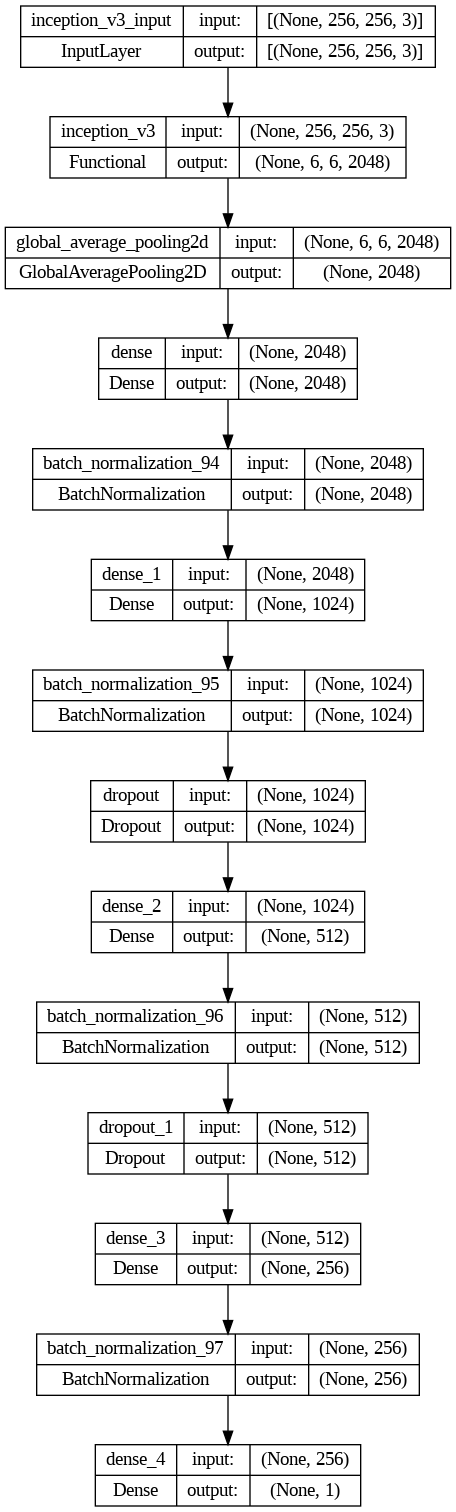

In [26]:
plot_model(model,show_layer_names=True,show_shapes=True)

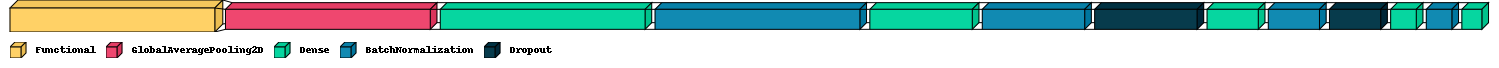

In [31]:
visualkeras.layered_view(model, legend=True)

In [9]:
modelcheck = ModelCheckpoint(filepath='model.h5',monitor='val_loss',save_best_only=True) # использую автоматическое сохранение лучшей модели, но далее всё равно на всякий случай сохраняю модель вручную
earlystop = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
tensorboard = TensorBoard(log_dir='logs')

### **Тренировка модели**



*   Оптимизатор: Используется оптимизатор Adam для обновления весов модели во время
обучения.
*   Функция потерь: Используется функция потерь binary_crossentropy для измерения ошибки между прогнозами модели и истинными значениями. Использую именно эту, поскольку у меня бинарная классификация

*   Метрики: Во время обучения отслеживаются две метрики: loss (потери) и accuracy (точность). Потери измеряют, насколько ошибочны прогнозы модели, а точность измеряет долю правильных прогнозов.
*   Коллбэки: Использование коллбэков во время обучения помогает улучшить процесс обучения и производительность модели.

    *   `ModelCheckpoint`: Сохраняет лучшую модель по показателю val_loss (потери на валидационной выборке) во время обучения.
    *   `EarlyStopping`: Останавливает обучение, если val_loss не улучшается в течение определенного количества эпох (эпоха - один проход через весь обучающий набор данных). Это помогает предотвратить переобучение.
    *   `TensorBoard`: Ведет журнал процесса обучения, который можно визуализировать в TensorBoard для мониторинга производительности модели.

In [10]:
history = model.fit(train_generator,validation_data=val_generator,epochs=20,callbacks=[modelcheck,earlystop,tensorboard])

Epoch 1/20
43/43 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.8917

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - 500s 11s/step - loss: 0.2590 - accuracy: 0.8917 - val_loss: 0.1976 - val_accuracy: 0.9520
Epoch 2/20
43/43 [==============================] - 317s 7s/step - loss: 0.1326 - accuracy: 0.9491 - val_loss: 0.1797 - val_accuracy: 0.9407
Epoch 3/20
43/43 [==============================] - 316s 7s/step - loss: 0.1163 - accuracy: 0.9571 - val_loss: 0.1471 - val_accuracy: 0.9435
Epoch 4/20
43/43 [==============================] - 320s 7s/step - loss: 0.0873 - accuracy: 0.9629 - val_loss: 0.1308 - val_accuracy: 0.9548
Epoch 5/20
43/43 [==============================] - 309s 7s/step - loss: 0.0755 - accuracy: 0.9760 - val_loss: 0.1417 - val_accuracy: 0.9435
Epoch 6/20
43/43 [==============================] - 312s 7s/step - loss: 0.0691 - accuracy: 0.9775 - val_loss: 0.1346 - val_accuracy: 0.9350
Epoch 7/20
43/43 [==============================] - 312s 7s/step - loss: 0.0473 - accuracy: 0.9833 - val_loss: 0.1036 - val_accuracy: 0.9605
Epoch 8/20
43/43 [=====

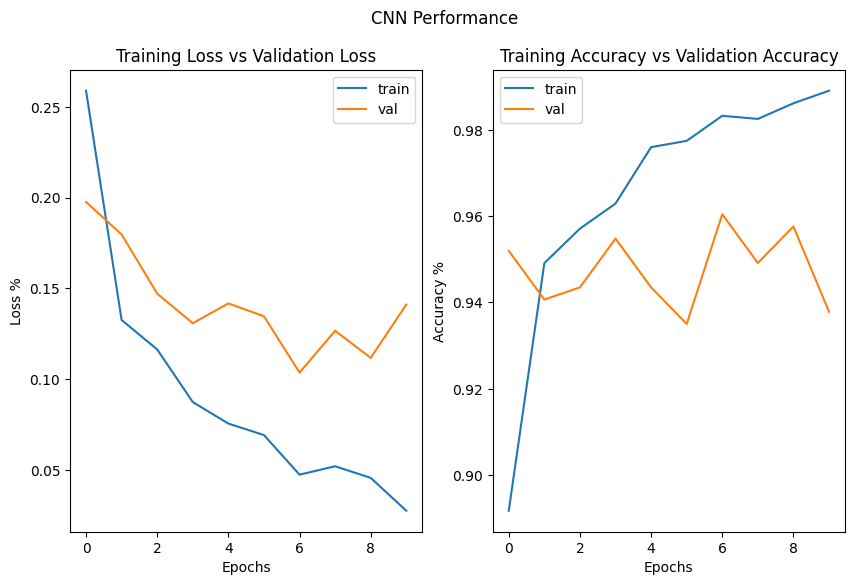

In [11]:
fig,ax = plt.subplots(1,2,figsize=(10,6))
total_epochs = [i for i in range(len(history.history['loss']))]
fig.suptitle("CNN Performance")

ax[0].plot(total_epochs,history.history['loss'],label='train')
ax[0].plot(total_epochs,history.history['val_loss'],label='val')
ax[0].set_title("Training Loss vs Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss %")
ax[0].legend(loc='best')

ax[1].plot(total_epochs,history.history['accuracy'],label='train')
ax[1].plot(total_epochs,history.history['val_accuracy'],label='val')
ax[1].set_title("Training Accuracy vs Validation Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy %")
ax[1].legend(loc='best')
plt.show()

In [12]:
model = tf.keras.models.load_model('model.h5')

In [35]:
loss,acc = model.evaluate(train_generator)
print(f'Training loss={loss}, Accuracy={acc}')

loss,acc = model.evaluate(val_generator)
print(f'Validation loss={loss}, Accuracy={acc}')

loss,acc = model.evaluate(test_generator)
print(f'Test loss={loss}, Accuracy={acc}')

43/43 [==============================] - 239s 5s/step - loss: 0.0270 - accuracy: 0.9964
Training loss=0.027043376117944717, Accuracy=0.9963662624359131
12/12 [==============================] - 71s 6s/step - loss: 0.1165 - accuracy: 0.9576
Validation loss=0.11652999371290207, Accuracy=0.9576271176338196
8/8 [==============================] - 47s 6s/step - loss: 0.1922 - accuracy: 0.9280
Test loss=0.19222424924373627, Accuracy=0.9279661178588867


<ipython-input-33-6e0cb7e93bb2>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


1/1 [==============================] - 0s 335ms/step


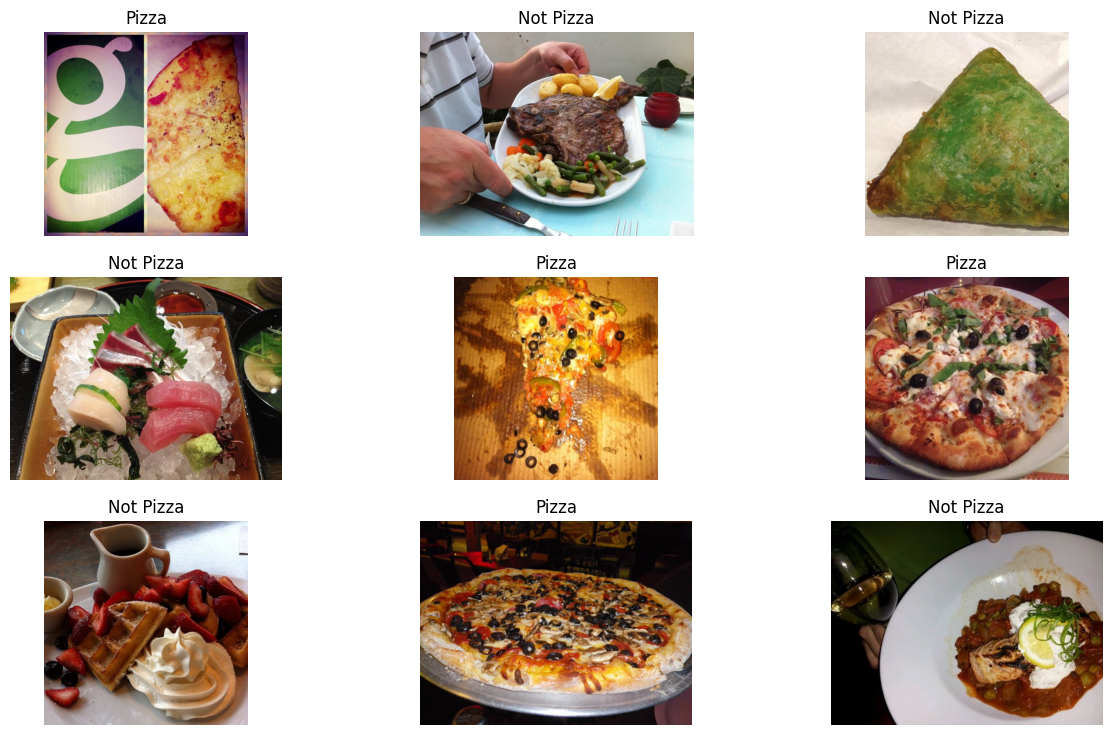

In [33]:
# Эта визуализация помогает оценить, насколько хорошо модель справляется с распознаванием пиццы на реальных изображениях
import cv2
sample_images = test_df.sample(n=9)
class_names = [item.name for item in data_dir.glob('*')][:2]
figure,ax = plt.subplots(figsize=(15,9))
for i,image in enumerate(sample_images.filename):
    plt.subplot(3,3,i+1)
    img = cv2.imread(image)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.axis('off')
    img = cv2.resize(img,(256,256))
    img = np.expand_dims(img,axis=0) # Добавляется новое измерение (batch size = 1), так как модель ожидает пакет изображений на входе
    img = img.astype('float32') # Значения пикселей преобразуются в тип float32, так как модель ожидает этот тип для вычислений в модели
    img = datagen.standardize(img) # Нормализация значений пикселей
    y_pred=model.predict(img)
    if y_pred > 0.5:
        plt.title('Pizza')
    else:
        plt.title("Not Pizza")
plt.show()

In [34]:
sample_images

,filename,category
1607,/content/drive/My Drive/pizza_not_pizza/pizza/...,1
746,/content/drive/My Drive/pizza_not_pizza/not_pi...,0
135,/content/drive/My Drive/pizza_not_pizza/not_pi...,0
331,/content/drive/My Drive/pizza_not_pizza/not_pi...,0
1417,/content/drive/My Drive/pizza_not_pizza/pizza/...,1
1580,/content/drive/My Drive/pizza_not_pizza/pizza/...,1
220,/content/drive/My Drive/pizza_not_pizza/not_pi...,0
1912,/content/drive/My Drive/pizza_not_pizza/pizza/...,1
905,/content/drive/My Drive/pizza_not_pizza/not_pi...,0


In [18]:
# preds=model.predict_generator(test_generator)

<ipython-input-18-98bcd331680f>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds=model.predict_generator(test_generator)


In [22]:
model.save('/content/drive/My Drive/last_model.h5')
# model.save('/content/drive/My Drive/my_model.h5') # сюда сохранять только если эта модель лучше прошлых

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Оценка модели**
*   Загрузка сохраненной модели: После обучения загружается лучшая сохраненная модель.
*   Оценка на тестовом наборе: Модель оценивается на тестовом наборе данных, чтобы получить unbiased (несмещенную) оценку ее производительности.
*   Печать результатов: Печатаются показатели потерь и точности на обучающем, валидационном и тестовом наборах данных.
*   Визуализация результатов: Выводятся случайные образцы изображений из тестового набора данных вместе с их предсказаниями.
*   Ручное сохранение последней и/или лучшей обученной модели



In [25]:
import telebot
import cv2
import numpy as np
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Загружаем модель машинного обучения
model = tf.keras.models.load_model('/content/drive/My Drive/my_model.h5')
datagen = ImageDataGenerator(rescale=1./255)

# Подключаемся к нашему боту через токен
bot = telebot.TeleBot('7169479433:AAGJY4uLCJL_T_14pFdTcO5p-MEQrr9akyY')

# Обработчик команды /start
@bot.message_handler(commands=['start'])
def start(message):
    bot.send_message(message.chat.id, 'Приветствую в пицца-боте! Отправьте фото, чтобы узнать, есть ли на нем пицца.')

# Обработчик фото
@bot.message_handler(content_types=['photo'])
def predict(message):

    photo_file = message.photo[-1] # Извлекает файл последнего фото, отправленного пользователем
    file_id = photo_file.file_id   # Получает id файла

    # Скачиваем фото
    try:
        file_info = bot.get_file(file_id)
        downloaded_file = bot.download_file(file_info.file_path)
    except Exception as e:
        print(f'Ошибка при скачивании фото: {e}. Пожалуйста, повторите попытку.')
        return

    # Преобразуем скачанное фото в массив NumPy
    image = np.fromstring(downloaded_file, dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR) # декодирование в BGR нужно для подготовки изображения к работе с OpenCV.

    # Предобработка изображения
    image = cv2.resize(image, (256, 256))
    image = Image.fromarray(image)
    image = np.array(image)
    image = image.astype('float32')
    image = datagen.standardize(np.expand_dims(image, axis=0))

    # Предсказание модели
    y_pred = model.predict(image)
    pizza_probability = y_pred[0][0]

    # Формирование ответа
    if pizza_probability > 0.5:
        response = f"На этом фото, скорее всего, пицца! (Вероятность: {pizza_probability:.2f})"
    else:
        response = f"На этом фото, скорее всего, не пицца. (Вероятность: {pizza_probability:.2f})"

    bot.send_message(message.chat.id, response)

# Запускаем бота
bot.polling()

<ipython-input-25-3dc78620d859>:36: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = np.fromstring(downloaded_file, dtype=np.uint8)


1/1 [==============================] - 0s 166ms/step
